In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import glob
import os


In [3]:
# get all files under src/round1
files = glob.glob('src/round1/round-1-island-data-bottle/*')
files

['src/round1/round-1-island-data-bottle\\prices_round_1_day_-1.csv',
 'src/round1/round-1-island-data-bottle\\prices_round_1_day_-2.csv',
 'src/round1/round-1-island-data-bottle\\prices_round_1_day_0.csv',
 'src/round1/round-1-island-data-bottle\\trades_round_1_day_-1_nn.csv',
 'src/round1/round-1-island-data-bottle\\trades_round_1_day_-2_nn.csv',
 'src/round1/round-1-island-data-bottle\\trades_round_1_day_0_nn.csv']

In [4]:
prices = []
trades = []
for file in files:
    if 'prices' in file:
        prices.append(pd.read_csv(file,sep=';'))
    else:
        tmp = pd.read_csv(file,sep=';')
        tmp['day'] = int(os.path.basename(file).split('day_')[1].split('_')[0])
        tmp = tmp.loc[:,['day']+list(tmp.columns[:-1])]
        trades.append(tmp)
        
prices = pd.concat(prices).sort_values(['day','timestamp']).reset_index()
trades = pd.concat(trades).sort_values(['day','timestamp']).reset_index()

In [5]:
prices

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,2,5055.0,24.0,NaN,NaN,5053.5,0.0
59996,19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,1,5054.0,27.0,NaN,NaN,5049.5,0.0
59997,19997,0,999800,AMETHYSTS,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
59998,19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,23,NaN,NaN,NaN,NaN,5051.0,0.0


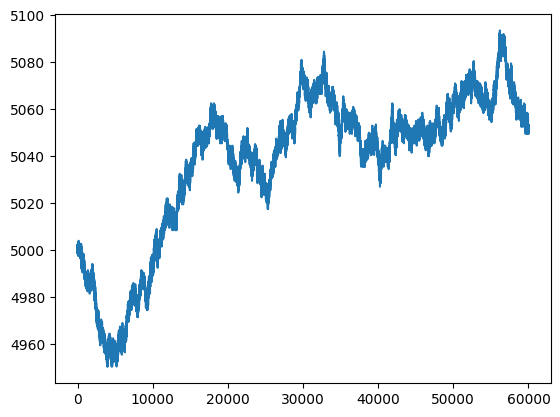

In [6]:
plt.plot(prices[prices['product']=='STARFRUIT']['mid_price'])

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
result = seasonal_decompose(prices[prices['product']=='STARFRUIT']['mid_price'], model='multiplicative', period=100)

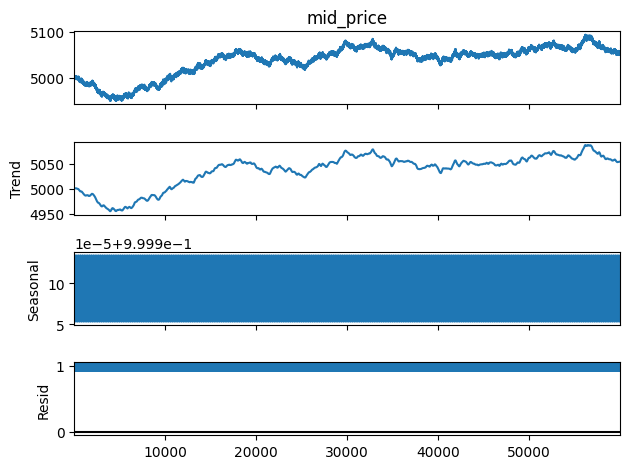

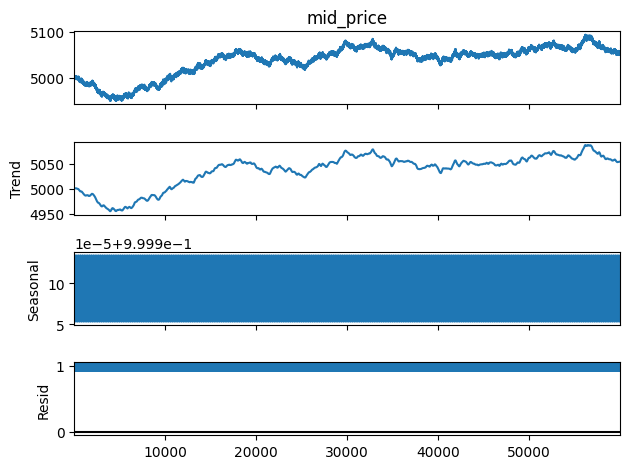

In [34]:
result.plot()

In [35]:
result.seasonal

1        1.000009
3        1.000020
4        1.000015
7        1.000022
9        0.999981
           ...   
59990    1.000011
59992    0.999975
59995    0.999988
59996    1.000000
59998    1.000007
Name: seasonal, Length: 30000, dtype: float64

In [18]:
result.resid.dropna()

10001    0.997124
10002    0.997174
10004    0.996823
10006    0.996976
10009    0.997271
           ...   
49990    0.998632
49993    0.998582
49995    0.998138
49997    0.998533
49998    0.998335
Name: resid, Length: 20000, dtype: float64

In [ ]:
model = auto_arima(prices[prices['product']=='STARFRUIT']['mid_price'], seasonal=True, m=10000)

In [ ]:
model.fit(prices[prices['product']=='STARFRUIT']['mid_price'])

In [41]:
prices[prices['product']=='STARFRUIT']['mid_price']

1        5000.0
3        5002.0
4        5000.0
7        4999.5
9        4998.5
          ...  
59990    5052.5
59992    5051.0
59995    5053.5
59996    5049.5
59998    5051.0
Name: mid_price, Length: 30000, dtype: float64

In [42]:
prices['total_vol'] = prices['bid_volume_1']+prices['ask_volume_1']+prices['bid_volume_2']+prices['ask_volume_2']+prices['bid_volume_3']+prices['ask_volume_3']

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,2,5055.0,24.0,NaN,NaN,5053.5,0.0
59996,19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,1,5054.0,27.0,NaN,NaN,5049.5,0.0
59997,19997,0,999800,AMETHYSTS,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
59998,19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,23,NaN,NaN,NaN,NaN,5051.0,0.0
